## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [2]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('..', 'keras_retinanet/bin/snapshots', 'vgg16_csv_10.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='vgg16')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'L', 1: 'R1', 2: 'R2'}

## Run detection on example

In [4]:
# load image
image = read_image_bgr('/home/dillon/python/projects/lead_detection/images/Image000100.BMP')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image, mode='pass')
image, scale = resize_image(image)

In [5]:
# process image
start = time.time()
boxes, scores, labels = model.predict(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

processing time:  5.736201286315918


In [7]:
predictions = np.concatenate((boxes[0], scores.T), axis=1)
predictions = np.concatenate((predictions, labels.T), axis=1)

In [8]:
boxes_df = pd.DataFrame(data=predictions,
                        columns=['xmin', 'ymin', 'xmax', 'ymax', 'score', 'label'])

In [9]:
boxes_df.shape

(300, 6)

In [10]:
filtered_boxes = boxes_df[boxes_df['score'] >= 0.90]
print(filtered_boxes.shape)

(47, 6)


In [11]:
def rectange_overlap(topleft_1, bottomright_1, topleft_2, bottomright_2):
    '''Check if rectanges overlap, return True for overlapping rectangles.
    
    Args:
        topleft_#, bottomright_# (tuple): (x, y) coordinates of rectangle corner
    Returns:
        bool: True for overlap, False for no overlap
    '''
    # Check if one rectangle is to the left of the other
    if topleft_1[0] > bottomright_2[0] or topleft_2[0] > bottomright_1[0]:
        return False
    # Check if one rectange is above the other
    if topleft_1[1] < bottomright_2[1] or topleft_2[1] < bottomright_1[1]:
        return False
    return True

In [12]:
selected_list = []
for index, row in filtered_boxes.iterrows():
    best_box = row
    row_topleft = (row['xmin'], row['ymax'])
    row_bottomright = (row['xmax'], row['ymin'])
    for i, r in filtered_boxes.iloc[index:].iterrows():
        r_topleft = (row['xmin'], row['ymax'])
        r_bottomright = (row['xmax'], row['ymin'])
        if rectange_overlap(row_topleft, row_bottomright, r_topleft, r_bottomright):
            if r['score'] >= row['score']:
                best_box = r
    selected_list.append(best_box)
    
selected_boxes = pd.DataFrame(data=selected_list,
                              columns=['xmin', 'ymin', 'xmax', 'ymax', 'score', 'label'])

In [13]:
selected_boxes.shape

(47, 6)

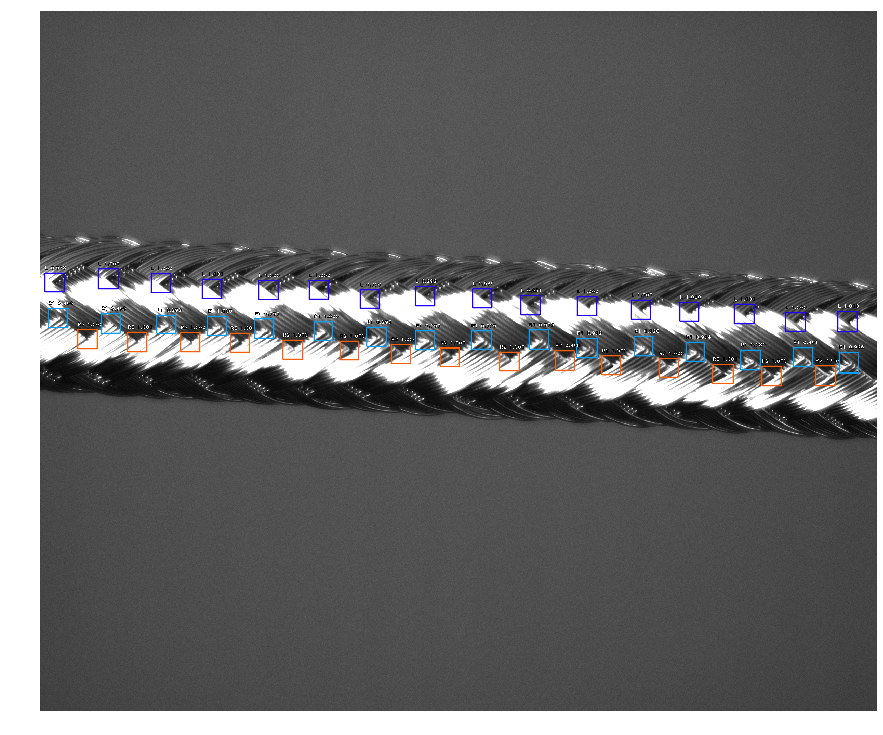

In [6]:
# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.90:
        break
    
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [14]:
selected_boxes.head(1)

,xmin,ymin,xmax,ymax,score,label
0,110.065613,933.79718,167.046753,989.473206,0.999999,2.0


In [15]:
label0_boxes = selected_boxes[selected_boxes['label'] == 2].sort_values(by=['xmin'])
label0_boxes

,xmin,ymin,xmax,ymax,score,label
0,110.065613,933.797180,167.046753,989.473206,0.999999,2.0
1,256.343567,941.850952,312.546204,998.596924,0.999998,2.0
7,411.335236,942.608459,467.928101,998.774353,0.999991,2.0
3,557.026428,944.860596,612.671265,999.199463,0.999998,2.0
17,710.913208,964.910522,768.880005,1020.736084,0.999812,2.0
6,877.572021,967.379395,931.116638,1022.561462,0.999995,2.0
13,1027.298706,977.720947,1083.730469,1032.839600,0.999907,2.0
2,1171.340454,987.073853,1226.207642,1041.630493,0.999998,2.0
20,1344.201294,999.626648,1401.139404,1054.558105,0.999767,2.0
38,1507.361084,995.192627,1562.383179,1052.057007,0.998442,2.0


In [16]:
label0_arr = label0_boxes.apply(lambda row: np.asarray([(np.mean([row.xmax, row.xmin]).astype(np.int)),
                                                          np.mean([row.ymax, row.ymin]).astype(np.int)]),
                                                          axis=1).values

In [28]:
label0_arr

array([array([138, 961]), array([284, 970]), array([439, 970]),
       array([584, 972]), array([739, 992]), array([904, 994]),
       array([1055, 1005]), array([1198, 1014]), array([1372, 1027]),
       array([1534, 1023]), array([1670, 1038]), array([1838, 1045]),
       array([1997, 1063]), array([2139, 1068]), array([2297, 1068])],
      dtype=object)

In [18]:
def pythagorean_distance(arr_1, arr_2):
    return np.sqrt((arr_2[0] - arr_1[0])**2 + (arr_2[1] - arr_1[1])**2)

In [19]:
label0_distance = np.asarray([pythagorean_distance(label0_arr[i], label0_arr[i+1]) for i in range(len(label0_arr) - 1)])

In [26]:
label0_lead_length = []
for i in range(len(label0_distance) % 12 + 1):
    label0_lead_length.append(np.sum(label0_distance[i:i+12]))

0 12
1 13
2 14


In [27]:
label0_lead_length

[1863.7915437716497, 1859.6024104375142, 1862.6024104375142]

In [29]:
img = read_image_bgr('/home/dillon/python/projects/lead_detection/images/Image000100.BMP')
img_bgr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
edges = cv2.Canny(img,10,88,10)

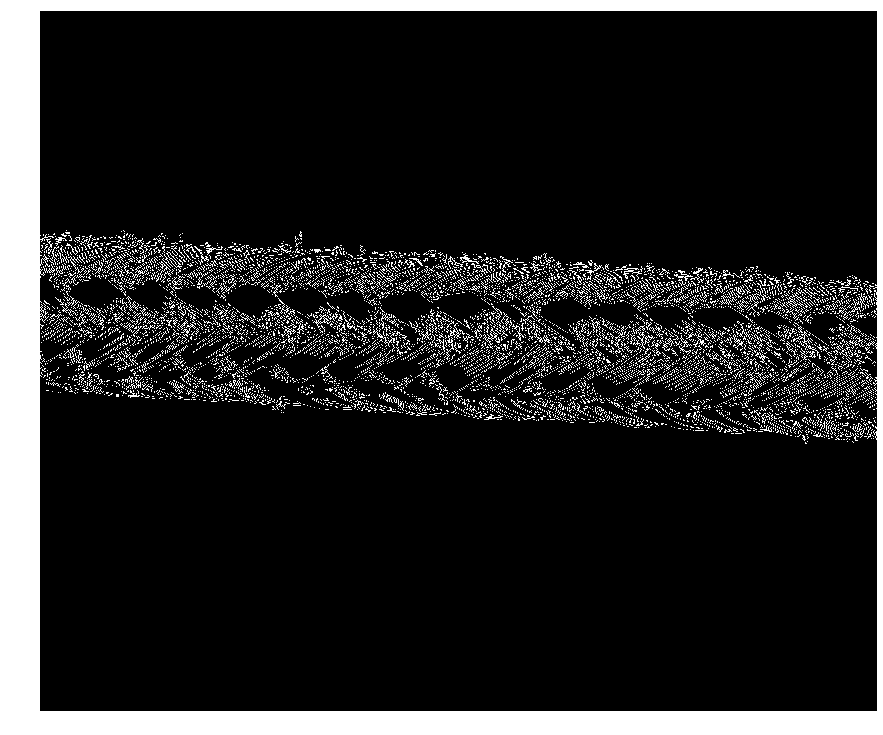

In [30]:
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(edges, cmap='gray')
plt.show()

In [31]:
top_edge = np.argmax(edges, 0)

In [32]:
top_fit = np.polyfit(np.arange(0, edges.shape[1], 1), top_edge, 1)
top_func = np.poly1d(top_fit)

In [33]:
flip_edges = np.flipud(edges)
bottom_edge = np.subtract(edges.shape[0], np.argmax(flip_edges, 0))

In [34]:
bottom_fit = np.polyfit(np.arange(0, edges.shape[1], 1), bottom_edge, 1)
bottom_func = np.poly1d(bottom_fit)

In [35]:
od_locations = np.arange(0, img.shape[1], int(img.shape[1] / 12))
braid_od = [bottom_func(x) - top_func(x) for x in od_locations]
braid_od_pix = np.mean(braid_od)

In [36]:
braid_od_mm = np.mean([11.75, 11.56, 11.62])
pix_per_mm = braid_od_pix / braid_od_mm
print("Pixels per mm: {0:.2f}".format(pix_per_mm))

Pixels per mm: 40.09


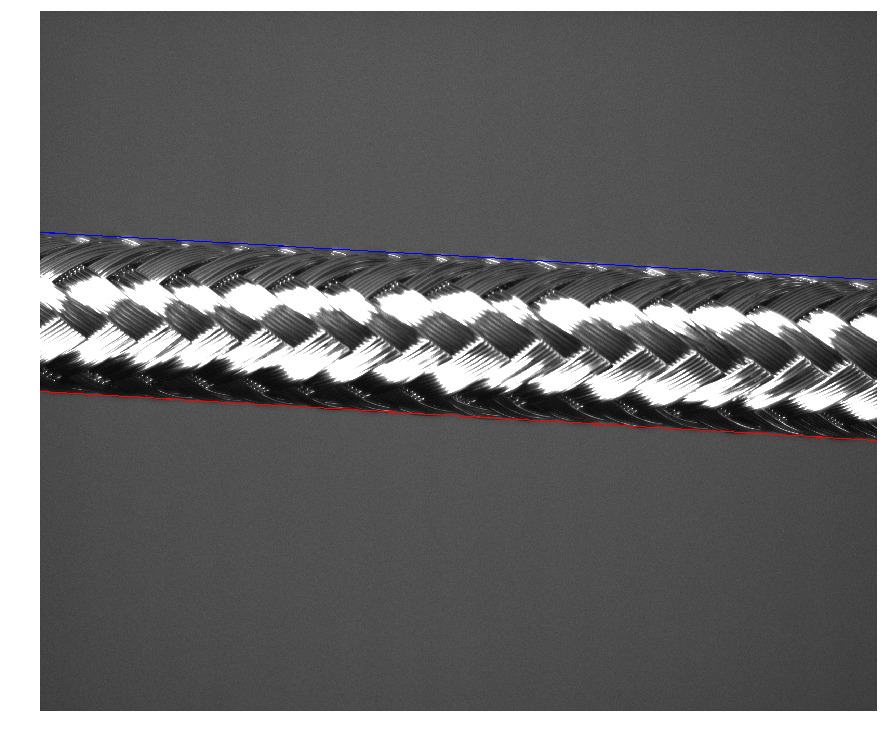

In [37]:
# Top boundary line
cv2.line(img, (0,int(top_func(0))), (2448,int(top_func(2448))), (0,0,255), 2)
# Bottom boundary line
cv2.line(img, (0,int(bottom_func(0))), (2448,int(bottom_func(2448))), (255,0,0), 2)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

In [38]:
avg_lead_length = np.mean(label0_lead_length)
print("Label0 lead length: {0:.2f}mm ({1:.4f}in)".format(avg_lead_length / pix_per_mm,
                                                         avg_lead_length / pix_per_mm / 25.4))
print("Target lead length: 1.75in")

Label0 lead length: 46.44mm (1.8284in)
Target lead length: 1.75in
